In [4]:
import pandas as pd
import numpy as np
import string
from pathlib import Path
from retell_utils.corpora_sugar import CorpusSugar
from retell_utils.metrics import get_cosine_sim, jaccard_text,show_statistics_and_bar
from tg.grammar_ru.corpus import CorpusReader
from tg.common.analysis import Bootstrap, Aggregators, grbar_plot
import retell_utils.statistical as stat_utils

In [5]:
retell_corpus = CorpusReader(Path("./featurized_corpuses/All retell.featurized.retell.corpus.zip"))
text_corpus = CorpusReader(Path("./featurized_corpuses/books.featurized.zip"))

In [6]:
corpus_sugar = CorpusSugar(text_corpus, retell_corpus)
books, retell_books, summar_books = corpus_sugar.get_books_retell_info_by_author('Мартин')

In [7]:
ban_words = set(string.punctuation + "«—»…")
ban_words.update(["!!", "!?", "?!", "??", "?.."])

In [8]:
stat_extract_retell = stat_utils.get_extract_retell_by_common_word(books,corpus_sugar.get_sentences_with_norm_form,ban_words=ban_words,retell_detail=5)

  0%|          | 0/82 [00:00<?, ?it/s]

In [9]:
true_retell = corpus_sugar.get_true_retell('Мартин',"retell",retell_detail=5)

In [10]:
jaccard_sim = np.array([jaccard_text(stat_extract_retell[i],true_retell[i]) for i in range(len(true_retell))])
cos_sim = np.array([get_cosine_sim(stat_extract_retell[i],true_retell[i]) for i in range(len(true_retell))])

median Индекс Жаккара: 0.095
max Индекс Жаккара: 0.17
min Индекс Жаккара: 0.044
------------------------------------
median Косинусное расстояние: 0.18
max Косинусное расстояние: 0.38
min Косинусное расстояние: 0.024
------------------------------------


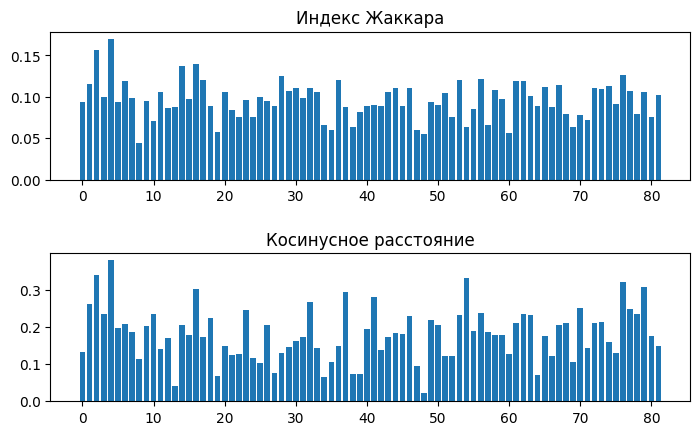

In [8]:
show_statistics_and_bar(jaccard_sim,cos_sim)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(pd_result)
/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(pd_result)
/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(pd_result)
/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.ap

<AxesSubplot: ylabel='metric_value'>

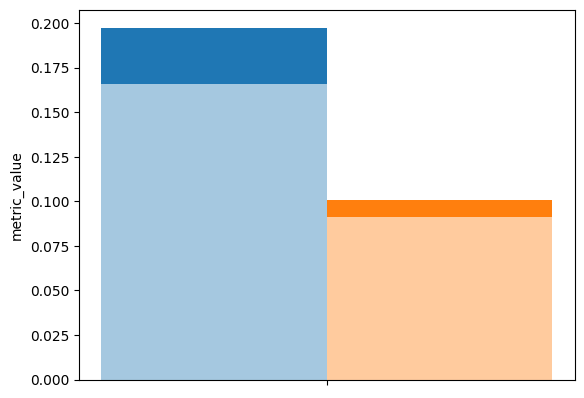

In [11]:
def compute(df):
    return df.groupby('metric_names').metric_values.mean().to_frame().transpose()

metrics_names = ["jaccard_sim" for _ in range(len(jaccard_sim))]+["cos_sim" for _ in range(len(cos_sim))]
df = pd.DataFrame(data=zip(np.concatenate([jaccard_sim,cos_sim]),metrics_names), columns=['metric_values','metric_names'])
rdf = Bootstrap(df = df, method = compute).run(N=1000)
rdf_i = rdf[['jaccard_sim','cos_sim']].unstack().to_frame().reset_index()
rdf_i.columns=['metric_names','iteration','metric']
grbar_plot(
    rdf_i.groupby('metric_names').metric.feed(Aggregators.normal_confint()).reset_index(),
    value_column='metric_value',
    error_column='metric_error',
    color_column='metric_names',
)